In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [280]:
full_medals = pd.read_csv('data/sim_full_medal_data.csv')
full_medals = full_medals.sort_values(by=['Country Code', 'Year']).reset_index(drop=True).dropna()
full_medals

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,3402,1026,38.0,Zimbabwe,1.0,3.0,0.0,4.0,2008,ZIM,0,0,0,16.0,15,302.0,8.0,5.0
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0


In [281]:
full_medals.loc[:, 'Possible Gold'] = full_medals.groupby('Year')['Gold'].transform('sum')
full_medals.loc[:, 'Possible Silver'] = full_medals.groupby('Year')['Silver'].transform('sum')
full_medals.loc[:, 'Possible Bronze'] = full_medals.groupby('Year')['Bronze'].transform('sum')

full_medals.loc[:, '% Female'] = full_medals.loc[:, 'Total Female Participants'] / (full_medals.loc[:, 'Total Female Participants'] + full_medals.loc[:, 'Total Male Participants'])

full_medals

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,141.0,140.0,141.0,0.000000
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,138.0,135.0,138.0,0.000000
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,153.0,153.0,163.0,0.000000
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,152.0,149.0,160.0,0.000000
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,167.0,174.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,3402,1026,38.0,Zimbabwe,1.0,3.0,0.0,4.0,2008,ZIM,0,0,0,16.0,15,302.0,8.0,5.0,302.0,303.0,353.0,0.384615
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,303.0,305.0,352.0,0.428571
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,307.0,359.0,0.700000
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,340.0,338.0,402.0,0.200000


In [282]:
def country_medals(country):
    medals = full_medals.where(full_medals['Country Code'] == country).dropna().sort_values(by="Year")
    return medals

rows = []
countries = full_medals['Country Code'].unique()

n = 3

for i in range(1, n+1):
    full_medals.loc[:, f'Gold - {i}'] = full_medals.groupby('Country Code')['Gold'].shift(periods=i)
    full_medals.loc[:, f'Silver - {i}'] = full_medals.groupby('Country Code')['Silver'].shift(periods=i)
    full_medals.loc[:, f'Bronze - {i}'] = full_medals.groupby('Country Code')['Bronze'].shift(periods=i)

    full_medals.loc[:, f'Team Size - {i}'] = full_medals.groupby('Country Code')['Team Size'].shift(periods=1)    

# full_medals.loc[:, f'Team Size - 1'] = full_medals.groupby('Country Code')['Team Size'].shift(periods=1)

full_medals = full_medals.fillna(0)
full_medals

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female,Gold - 1,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Gold - 3,Silver - 3,Bronze - 3,Team Size - 3
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,141.0,140.0,141.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,138.0,135.0,138.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,153.0,153.0,163.0,0.000000,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,152.0,149.0,160.0,0.000000,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,167.0,174.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,3402,1026,38.0,Zimbabwe,1.0,3.0,0.0,4.0,2008,ZIM,0,0,0,16.0,15,302.0,8.0,5.0,302.0,303.0,353.0,0.384615,1.0,1.0,1.0,14.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,14.0
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,303.0,305.0,352.0,0.428571,1.0,3.0,0.0,16.0,1.0,1.0,1.0,16.0,0.0,0.0,0.0,16.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,307.0,359.0,0.700000,0.0,0.0,0.0,9.0,1.0,3.0,0.0,9.0,1.0,1.0,1.0,9.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,340.0,338.0,402.0,0.200000,0.0,0.0,0.0,31.0,0.0,0.0,0.0,31.0,1.0,3.0,0.0,31.0


In [283]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = full_medals[['Gold - 1', 'Gold - 2', 'Gold - 3', 'Silver - 1', 'Silver - 2', 'Silver - 3', 'Bronze - 1', 'Bronze - 2', 'Bronze - 3', 'Ex-Host', 'Team Size', 'Participated Events', '% Female', 'Year', 'Possible Gold', 'Possible Silver', 'Possible Bronze', 'Gold', 'Silver', 'Bronze']]

train = data[data['Year'] <= 2012]
test = data[data['Year'] > 2012]

X_train = train.iloc[:, :-7]
y_train = train.iloc[:, -7:]
X_test = test.iloc[:, :-7]
y_test = test.iloc[:, -7:]


truth_counts_train = y_train.iloc[:, :]
y_train = y_train.iloc[:, 4:]
truth_counts_test = y_test.iloc[:, :]
y_test = y_test.iloc[:, 4:]

In [284]:
def scale_predictions(predictions, possible_counts):
    possible_counts = possible_counts.reset_index(drop=True)
    predictions = predictions.reset_index(drop=True)

    possible_counts[['Predicted Gold', 'Predicted Silver', 'Predicted Bronze']] = predictions[['Gold', 'Silver', 'Bronze']]
    possible_counts[['Predicted Upper Gold', 'Predicted Upper Silver', 'Predicted Upper Bronze']] = predictions[['Upper Gold', 'Upper Silver', 'Upper Bronze']]
    possible_counts[['Predicted Lower Gold', 'Predicted Lower Silver', 'Predicted Lower Bronze']] = predictions[['Lower Gold', 'Lower Silver', 'Lower Bronze']]

    gold = ((possible_counts['Predicted Gold'] / possible_counts.groupby('Year')['Predicted Gold'].transform('sum')) * possible_counts['Possible Gold']).astype(int)
    silver = ((possible_counts['Predicted Silver'] / possible_counts.groupby('Year')['Predicted Silver'].transform('sum')) * possible_counts['Possible Silver']).astype(int)
    bronze = ((possible_counts['Predicted Bronze'] / possible_counts.groupby('Year')['Predicted Bronze'].transform('sum')) * possible_counts['Possible Bronze']).astype(int)

    upper_gold = ((possible_counts['Predicted Upper Gold'] / possible_counts.groupby('Year')['Predicted Upper Gold'].transform('sum')) * possible_counts['Possible Gold']).astype(int)
    upper_silver = ((possible_counts['Predicted Upper Silver'] / possible_counts.groupby('Year')['Predicted Upper Silver'].transform('sum')) * possible_counts['Possible Silver']).astype(int)
    upper_bronze = ((possible_counts['Predicted Upper Bronze'] / possible_counts.groupby('Year')['Predicted Upper Bronze'].transform('sum')) * possible_counts['Possible Bronze']).astype(int)

    lower_gold = ((possible_counts['Predicted Lower Gold'] / possible_counts.groupby('Year')['Predicted Lower Gold'].transform('sum')) * possible_counts['Possible Gold']).astype(int)
    lower_silver = ((possible_counts['Predicted Lower Silver'] / possible_counts.groupby('Year')['Predicted Lower Silver'].transform('sum')) * possible_counts['Possible Silver']).astype(int)
    lower_bronze = ((possible_counts['Predicted Lower Bronze'] / possible_counts.groupby('Year')['Predicted Lower Bronze'].transform('sum')) * possible_counts['Possible Bronze']).astype(int)

    return pd.DataFrame({'Gold': gold, 'Silver': silver, 'Bronze': bronze, 'Upper Gold': upper_gold, 'Upper Silver': upper_silver, 'Upper Bronze': upper_bronze, 'Lower Gold': lower_gold, 'Lower Silver': lower_silver, 'Lower Bronze': lower_bronze})


In [285]:
def train_model(X_train, y_train, X_test, n_iterations=100):
    predictions = np.zeros(shape=(n_iterations, len(X_test), len(y_train.columns.values)))
    
    for i in range(n_iterations):
        # Create a bootstrapped dataset
        indices = np.random.choice(len(X_train), len(X_train), replace=True)
        
        X_resampled = X_train.iloc[indices, :]
        y_resampled = y_train.iloc[indices, :]
    
        for j in range(len(y_train.columns.values)):
            # Train an XGBoost model
            model = XGBRegressor()
            model.fit(X_resampled, y_resampled.iloc[:, j])
            
            # Predict on test data
            preds = model.predict(X_test)
            predictions[i,:,j] = preds
    
    
    # # Calculate the mean and standard deviation of the predictions
    mean_preds = np.mean(predictions, axis=0)
    std_preds = np.std(predictions, axis=0)
    
    # # Confidence intervals
    lower_bound = mean_preds - 1.96 * std_preds
    upper_bound = mean_preds + 1.96 * std_preds

    predictions = pd.DataFrame(mean_preds, columns=['Gold', 'Silver', 'Bronze'])
    predictions.loc[:, ['Upper Gold', 'Upper Silver', 'Upper Bronze']] = upper_bound
    predictions.loc[:, ['Lower Gold', 'Lower Silver', 'Lower Bronze']] = lower_bound

    return predictions

In [287]:
predictions = train_model(X_train, y_train, X_test)

In [288]:
np.set_printoptions(suppress=True)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test['Gold'], predictions['Gold']))
print(mean_absolute_error(y_test['Silver'], predictions['Silver']))
print(mean_absolute_error(y_test['Bronze'], predictions['Bronze']))

0.6819174881666824
0.7432712973327007
0.7660157478309947


In [289]:
corrected = scale_predictions(predictions, truth_counts_test)

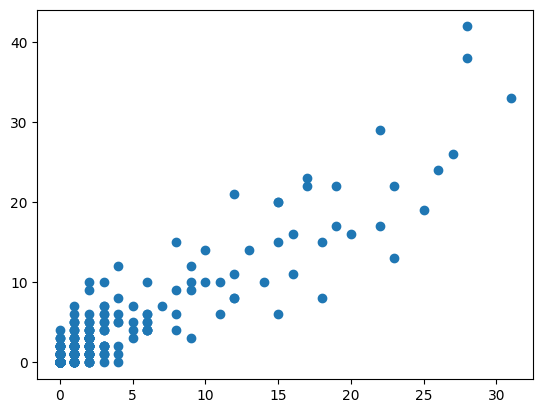

In [293]:
plt.scatter(corrected['Bronze'], y_test['Bronze'])

In [294]:
sim_data = pd.read_csv('data/sim_full_medal_data.csv').sort_values(by=['Country Code', 'Year']).reset_index(drop=True)
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0


In [295]:
sim_data.loc[:, 'Possible Gold'] = sim_data.loc[:, 'Total Events']
sim_data.loc[:, 'Possible Silver'] = sim_data.loc[:, 'Total Events']
sim_data.loc[:, 'Possible Bronze'] = sim_data.loc[:, 'Total Events']
sim_data.loc[:, '% Female'] = sim_data.loc[:, 'Total Female Participants'] / (sim_data.loc[:, 'Total Female Participants'] + sim_data.loc[:, 'Total Male Participants'])
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,129.0,129.0,129.0,0.000000
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,136.0,136.0,136.0,0.000000
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,151.0,151.0,151.0,0.000000
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,150.0,150.0,150.0,0.000000
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,163.0,163.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,302.0,302.0,302.0,0.428571
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,306.0,306.0,0.700000
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,339.0,339.0,339.0,0.200000
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0,329.0,329.0,329.0,0.285714


In [296]:
n = 3

for i in range(1, n+1):
    sim_data.loc[:, f'Gold - {i}'] = sim_data.groupby('Country Code')['Gold'].shift(periods=i)
    sim_data.loc[:, f'Silver - {i}'] = sim_data.groupby('Country Code')['Silver'].shift(periods=i)
    sim_data.loc[:, f'Bronze - {i}'] = sim_data.groupby('Country Code')['Bronze'].shift(periods=i)

    sim_data.loc[:, f'Team Size - {i}'] = sim_data.groupby('Country Code')['Team Size'].shift(periods=1)    

# full_medals.loc[:, f'Team Size - 1'] = full_medals.groupby('Country Code')['Team Size'].shift(periods=1)

sim_data = sim_data.fillna(0)
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female,Gold - 1,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Gold - 3,Silver - 3,Bronze - 3,Team Size - 3
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,129.0,129.0,129.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,136.0,136.0,136.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,151.0,151.0,151.0,0.000000,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,150.0,150.0,150.0,0.000000,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,163.0,163.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,302.0,302.0,302.0,0.428571,1.0,3.0,0.0,16.0,1.0,1.0,1.0,16.0,0.0,0.0,0.0,16.0
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,306.0,306.0,0.700000,0.0,0.0,0.0,9.0,1.0,3.0,0.0,9.0,1.0,1.0,1.0,9.0
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,339.0,339.0,339.0,0.200000,0.0,0.0,0.0,31.0,0.0,0.0,0.0,31.0,1.0,3.0,0.0,31.0
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0,329.0,329.0,329.0,0.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0


In [297]:
data = sim_data[['Gold - 1', 'Gold - 2', 'Gold - 3', 'Silver - 1', 'Silver - 2', 'Silver - 3', 'Bronze - 1', 'Bronze - 2', 'Bronze - 3', 'Ex-Host', 'Team Size', 'Participated Events', '% Female', 'Year', 'Possible Gold', 'Possible Silver', 'Possible Bronze', 'Gold', 'Silver', 'Bronze']]

train = data[data['Year'] <= 2024]
test = data[data['Year'] >= 2028]


X_train = train.iloc[:, :-7]
y_train = train.iloc[:, -7:]
y_train = y_train.iloc[:, 4:]

X_test = test.iloc[:, :-7]

predictions = train_model(X_train, y_train, X_test, n_iterations=100)

test.loc[:, ['Predicted Gold', 'Predicted Silver', 'Predicted Bronze']] = predictions.loc[:, ['Gold', 'Silver', 'Bronze']].values
test.loc[:, ['Predicted Upper Gold', 'Predicted Upper Silver', 'Predicted Upper Bronze']] = predictions.loc[:, ['Upper Gold', 'Upper Silver', 'Upper Bronze']].values
test.loc[:, ['Predicted Lower Gold', 'Predicted Lower Silver', 'Predicted Lower Bronze']] = predictions.loc[:, ['Lower Gold', 'Lower Silver', 'Lower Bronze']].values

display(test)

test.loc[:, 'Gold'] = ((test['Predicted Gold'] / test.groupby('Year')['Predicted Gold'].transform('sum')) * test['Possible Gold']).astype(int)
test.loc[:, 'Silver'] = ((test['Predicted Silver'] / test.groupby('Year')['Predicted Silver'].transform('sum')) * test['Possible Silver']).astype(int)
test.loc[:, 'Bronze'] = ((test['Predicted Bronze'] / test.groupby('Year')['Predicted Bronze'].transform('sum')) * test['Possible Bronze']).astype(int)

test.loc[:, 'Upper Gold'] = ((test['Predicted Upper Gold'] / test.groupby('Year')['Predicted Gold'].transform('sum')) * test['Possible Gold']).astype(int)
test.loc[:, 'Upper Silver'] = ((test['Predicted Upper Silver'] / test.groupby('Year')['Predicted Silver'].transform('sum')) * test['Possible Silver']).astype(int)
test.loc[:, 'Upper Bronze'] = ((test['Predicted Upper Bronze'] / test.groupby('Year')['Predicted Bronze'].transform('sum')) * test['Possible Bronze']).astype(int)

test.loc[:, 'Lower Gold'] = ((test['Predicted Lower Gold'] / test.groupby('Year')['Predicted Gold'].transform('sum')) * test['Possible Gold']).astype(int)
test.loc[:, 'Lower Silver'] = ((test['Predicted Lower Silver'] / test.groupby('Year')['Predicted Silver'].transform('sum')) * test['Possible Silver']).astype(int)
test.loc[:, 'Lower Bronze'] = ((test['Predicted Lower Bronze'] / test.groupby('Year')['Predicted Bronze'].transform('sum')) * test['Possible Bronze']).astype(int)

test.loc[:, 'Total'] = test[['Gold', 'Silver', 'Bronze']].sum(axis=1)
test.loc[:, 'Rank'] = test['Total'].rank(ascending = False)

test[test['Gold'] > 3]


,Gold - 1,Gold - 2,Gold - 3,Silver - 1,Silver - 2,Silver - 3,Bronze - 1,Bronze - 2,Bronze - 3,Ex-Host,Team Size,Participated Events,% Female,Year,Possible Gold,Possible Silver,Possible Bronze,Gold,Silver,Bronze,Predicted Gold,Predicted Silver,Predicted Bronze,Predicted Upper Gold,Predicted Upper Silver,Predicted Upper Bronze,Predicted Lower Gold,Predicted Lower Silver,Predicted Lower Bronze
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6.0,5,0.400000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.009090,0.002207,0.007591,0.031223,0.025051,0.038468,-0.013043,-0.020636,-0.023286
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,46.0,30,0.531250,2028,329.0,329.0,329.0,0.0,0.0,0.0,0.146302,0.263330,0.288707,0.485599,0.782856,0.731775,-0.192995,-0.256195,-0.154360
42,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,9.0,9,0.375000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.175843,0.208300,0.580435,0.447979,0.570696,1.426797,-0.096293,-0.154095,-0.265927
58,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0,50.0,45,0.372093,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.961399,1.451823,1.564178,1.844725,2.522684,2.742688,0.078073,0.380962,0.385667
72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,3,0.500000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.006756,-0.000957,-0.003302,0.018472,0.004501,0.005248,-0.004960,-0.006415,-0.011852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,21.0,20,0.647059,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.057437,0.056187,0.092884,0.476123,0.409145,0.616471,-0.361249,-0.296770,-0.430703
3339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,3,0.666667,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.001884,-0.002629,-0.003284,0.010141,0.003524,0.005525,-0.006374,-0.008781,-0.012094
3358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,5,0.250000,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.043653,0.066126,0.028453,0.149217,0.175129,0.069073,-0.061910,-0.042877,-0.012167
3391,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,31.0,9,0.766667,2028,334.0,334.0,334.0,0.0,0.0,0.0,0.116253,0.120685,0.167633,0.438167,0.540859,0.646573,-0.205662,-0.299489,-0.311307


/var/folders/5c/216t7l5x1_j3zsn2fm8z7s180000gn/T/ipykernel_79302/2294644816.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Upper Gold'] = ((test['Predicted Upper Gold'] / test.groupby('Year')['Predicted Gold'].transform('sum')) * test['Possible Gold']).astype(int)
/var/folders/5c/216t7l5x1_j3zsn2fm8z7s180000gn/T/ipykernel_79302/2294644816.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Upper Silver'] = ((test['Predicted Upper Silver'] / test.groupby('Year')['Predicted Si

,Gold - 1,Gold - 2,Gold - 3,Silver - 1,Silver - 2,Silver - 3,Bronze - 1,Bronze - 2,Bronze - 3,Ex-Host,Team Size,Participated Events,% Female,Year,Possible Gold,Possible Silver,Possible Bronze,Gold,Silver,Bronze,Predicted Gold,Predicted Silver,Predicted Bronze,Predicted Upper Gold,Predicted Upper Silver,Predicted Upper Bronze,Predicted Lower Gold,Predicted Lower Silver,Predicted Lower Bronze,Upper Gold,Upper Silver,Upper Bronze,Lower Gold,Lower Silver,Lower Bronze,Total,Rank
186,18.0,17.0,8.0,19.0,7.0,11.0,16.0,22.0,10.0,2,643.0,199,0.545643,2028,334.0,334.0,334.0,21.0,17.0,14.0,23.732994,17.986056,16.917375,45.838908,29.491249,24.758940,1.627081,6.480863,9.075809,40,28,21,1,6,7,52.0,5.0
447,3.0,7.0,7.0,7.0,6.0,6.0,10.0,8.0,6.0,1,408.0,144,0.516447,2028,334.0,334.0,334.0,5.0,6.0,8.0,5.785104,6.789743,9.542807,8.436320,9.478833,12.738074,3.133887,4.100652,6.347539,7,9,11,2,3,5,19.0,13.0
556,9.0,7.0,4.0,7.0,7.0,3.0,11.0,10.0,15.0,1,523.0,177,0.610028,2028,334.0,334.0,334.0,9.0,8.0,11.0,10.253233,9.232205,13.532784,13.947777,12.989040,17.596923,6.558689,5.475370,9.468644,12,12,15,5,5,8,28.0,10.0
640,40.0,38.0,26.0,27.0,32.0,18.0,24.0,19.0,26.0,1,580.0,210,0.678922,2028,334.0,334.0,334.0,31.0,27.0,24.0,35.725095,28.462187,27.461663,44.517441,37.539949,34.901948,26.932750,19.384424,20.021378,39,35,30,24,18,17,82.0,2.0
968,5.0,3.0,7.0,4.0,8.0,4.0,9.0,6.0,6.0,1,477.0,148,0.467391,2028,334.0,334.0,334.0,6.0,7.0,8.0,7.026976,8.075411,10.041553,11.367795,12.024742,14.575325,2.686157,4.126080,5.507781,10,11,12,2,3,4,21.0,11.0
1076,16.0,10.0,10.0,26.0,12.0,18.0,22.0,11.0,14.0,3,669.0,208,0.469880,2028,334.0,334.0,334.0,18.0,20.0,17.0,21.270678,21.381534,19.549518,33.305555,35.792098,26.474160,9.235802,6.970970,12.624875,29,34,23,8,6,11,55.0,4.0
1145,14.0,22.0,27.0,22.0,20.0,23.0,29.0,22.0,17.0,3,540.0,185,0.525886,2028,334.0,334.0,334.0,14.0,15.0,15.0,16.602710,16.460079,18.128447,25.715307,24.059375,26.098036,7.490114,8.860782,10.158858,22,22,22,6,8,8,44.0,6.0
1202,12.0,10.0,17.0,13.0,11.0,10.0,8.0,16.0,15.0,2,622.0,201,0.450575,2028,334.0,334.0,334.0,12.0,12.0,15.0,14.043306,12.936186,17.140082,18.554873,18.284337,21.964150,9.531738,7.588035,12.316014,16,17,19,8,7,10,39.0,7.5
1406,6.0,6.0,8.0,7.0,7.0,3.0,6.0,7.0,4.0,0,246.0,112,0.505747,2028,334.0,334.0,334.0,6.0,6.0,5.0,7.142200,6.507515,5.977776,10.142684,8.528848,8.920683,4.141716,4.486183,3.034868,9,8,7,3,4,2,17.0,15.0
1605,12.0,10.0,8.0,13.0,10.0,12.0,15.0,20.0,8.0,1,567.0,201,0.484536,2028,334.0,334.0,334.0,13.0,13.0,13.0,15.250812,13.711794,15.209457,22.675076,17.756331,20.197787,7.826548,9.667257,10.221126,20,16,17,6,9,8,39.0,7.5


In [298]:
sim_data.loc[test.index.values, ['Gold', 'Silver', 'Bronze', 'Upper Gold', 'Upper Silver', 'Upper Bronze', 'Lower Gold', 'Lower Silver', 'Lower Bronze', 'Total', 'Rank']] = test.loc[:, ['Gold', 'Silver', 'Bronze', 'Upper Gold', 'Upper Silver', 'Upper Bronze', 'Lower Gold', 'Lower Silver', 'Lower Bronze', 'Total', 'Rank']]
sim_data

,Unnamed: 0.1,Unnamed: 0,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female,Gold - 1,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Gold - 3,Silver - 3,Bronze - 3,Team Size - 3,Upper Gold,Upper Silver,Upper Bronze,Lower Gold,Lower Silver,Lower Bronze
0,0,1522,0.0,Afghanistan,0.0,0.0,0.0,0.0,1936,AFG,0,0,0,16.0,4,129.0,15.0,0.0,129.0,129.0,129.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1540,0.0,Afghanistan,0.0,0.0,0.0,0.0,1948,AFG,0,0,0,25.0,2,136.0,22.0,0.0,136.0,136.0,136.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1584,0.0,Afghanistan,0.0,0.0,0.0,0.0,1956,AFG,0,0,0,12.0,1,151.0,12.0,0.0,151.0,151.0,151.0,0.000000,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1653,0.0,Afghanistan,0.0,0.0,0.0,0.0,1960,AFG,0,0,0,16.0,13,150.0,12.0,0.0,150.0,150.0,150.0,0.000000,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1674,0.0,Afghanistan,0.0,0.0,0.0,0.0,1964,AFG,0,0,1,8.0,8,163.0,8.0,0.0,163.0,163.0,163.0,0.000000,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,3403,2814,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2012,ZIM,0,0,0,9.0,8,302.0,4.0,3.0,302.0,302.0,302.0,0.428571,1.0,3.0,0.0,16.0,1.0,1.0,1.0,16.0,0.0,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
3404,3404,2916,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2016,ZIM,0,0,0,31.0,13,306.0,9.0,21.0,306.0,306.0,306.0,0.700000,0.0,0.0,0.0,9.0,1.0,3.0,0.0,9.0,1.0,1.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
3405,3405,3079,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2020,ZIM,0,0,0,5.0,5,339.0,4.0,1.0,339.0,339.0,339.0,0.200000,0.0,0.0,0.0,31.0,0.0,0.0,0.0,31.0,1.0,3.0,0.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
3406,3406,3149,0.0,Zimbabwe,0.0,0.0,0.0,0.0,2024,ZIM,0,0,0,7.0,6,329.0,5.0,2.0,329.0,329.0,329.0,0.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN


In [299]:
sim_data = sim_data.fillna(0)

,Year,Gold,Silver,Bronze,Total,Is_Host,Ex-Host,Host Continent,Team Size,Possible Bronze,Possible Silver,Possible Bronze
3244,1896,11.0,7.0,2.0,20.0,0,0,0,27.0,43.0,43.0,43.0
3245,1900,19.0,14.0,15.0,48.0,0,0,0,135.0,97.0,97.0,97.0
3246,1904,76.0,78.0,77.0,231.0,1,1,1,1109.0,95.0,95.0,95.0
3247,1908,23.0,12.0,12.0,47.0,0,1,0,219.0,110.0,110.0,110.0
3248,1912,26.0,19.0,19.0,64.0,0,1,0,364.0,102.0,102.0,102.0
3249,1920,41.0,27.0,27.0,95.0,0,1,0,473.0,156.0,156.0,156.0
3250,1924,45.0,27.0,27.0,99.0,0,1,0,459.0,126.0,126.0,126.0
3251,1928,22.0,18.0,16.0,56.0,0,1,0,426.0,109.0,109.0,109.0
3252,1932,44.0,36.0,30.0,110.0,1,2,1,743.0,117.0,117.0,117.0
3253,1936,24.0,21.0,12.0,57.0,0,2,0,487.0,129.0,129.0,129.0


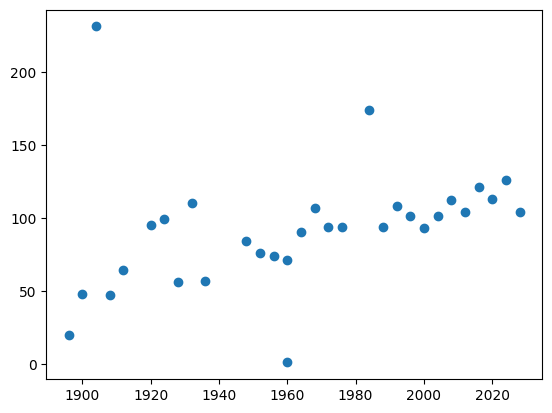

In [301]:
display(sim_data[sim_data['NOC'] == 'United States'].loc[:, ['Year', 'Gold', 'Silver', 'Bronze', 'Total', 'Is_Host', 'Ex-Host', 'Host Continent', 'Team Size', 'Possible Bronze', 'Possible Silver', 'Possible Bronze']])
plt.scatter(sim_data[sim_data['NOC'] == 'United States']['Year'], sim_data[sim_data['NOC'] == 'United States']['Total'])

In [302]:
export = sim_data[['Year', 'Country Code', 'Gold', 'Silver', 'Bronze', 'Upper Gold', 'Upper Silver', 'Upper Bronze', 'Lower Gold', 'Lower Silver', 'Lower Bronze', 'Total', 'Rank']][sim_data['Year'] == 2028].sort_values('Rank', ascending=True).reset_index(drop=True)
display(export)
export.to_csv('data/projected_medals_2028_xgboost.csv')

,Year,Country Code,Gold,Silver,Bronze,Upper Gold,Upper Silver,Upper Bronze,Lower Gold,Lower Silver,Lower Bronze,Total,Rank
0,2028,USA,38.0,37.0,29.0,48.0,47.0,36.0,28.0,27.0,21.0,104.0,1.0
1,2028,CHN,31.0,27.0,24.0,39.0,35.0,30.0,24.0,18.0,17.0,82.0,2.0
2,2028,JPN,34.0,25.0,20.0,63.0,47.0,29.0,5.0,4.0,11.0,79.0,3.0
3,2028,FRA,18.0,20.0,17.0,29.0,34.0,23.0,8.0,6.0,11.0,55.0,4.0
4,2028,AUS,21.0,17.0,14.0,40.0,28.0,21.0,1.0,6.0,7.0,52.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2028,HON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.5
202,2028,IRQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.5
203,2028,ISL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.5
204,2028,IVB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.5


In [303]:
most_improved = sim_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
most_improved = most_improved.sort_values(['Country Code', 'Year'])
most_improved['Difference'] = most_improved.groupby(['Country Code'])['Total'].diff().fillna(0)
most_improved['Cumulative Sum'] = most_improved.groupby(['Country Code'])['Total'].cumsum()
most_improved['Cumulative Sum'] = most_improved.groupby(['Country Code'])['Cumulative Sum'].shift()
most_improved = most_improved.fillna(0)
most_improved['% Difference'] = most_improved['Difference'] / most_improved['Cumulative Sum']

most_improved_raw = most_improved.sort_values(by='Difference', ascending=False).loc[most_improved['Year'] == 2028].reset_index(drop=True)
most_improved_pct = most_improved.sort_values(by='% Difference', ascending=False).loc[most_improved['Year'] == 2028].reset_index(drop=True)

# most_improved.loc[row]

In [304]:
display(most_improved_pct)

,Rank,NOC,Gold,Silver,Bronze,Total,Year,Country Code,Is_Host,Ex-Host,Host Continent,Team Size,Participated Events,Total Events,Total Male Participants,Total Female Participants,Possible Gold,Possible Silver,Possible Bronze,% Female,Gold - 1,Silver - 1,Bronze - 1,Team Size - 1,Gold - 2,Silver - 2,Bronze - 2,Team Size - 2,Gold - 3,Silver - 3,Bronze - 3,Team Size - 3,Upper Gold,Upper Silver,Upper Bronze,Lower Gold,Lower Silver,Lower Bronze,Difference,Cumulative Sum,% Difference
0,3.0,Japan,34.0,25.0,20.0,79.0,2028,JPN,0,2,0,692.0,194,334.0,276.0,246.0,334.0,334.0,334.0,0.471264,20.0,12.0,13.0,598.0,27.0,14.0,17.0,598.0,12.0,8.0,21.0,598.0,63.0,47.0,29.0,5.0,4.0,11.0,34.0,544.0,0.062500
1,35.5,Egypt,1.0,2.0,2.0,5.0,2028,EGY,0,0,0,201.0,91,334.0,98.0,51.0,334.0,334.0,334.0,0.342282,1.0,1.0,1.0,207.0,1.0,1.0,4.0,207.0,0.0,0.0,3.0,207.0,3.0,3.0,3.0,0.0,0.0,0.0,2.0,39.0,0.051282
2,28.5,Serbia,2.0,2.0,2.0,6.0,2028,SRB,0,0,0,122.0,47,334.0,56.0,44.0,334.0,334.0,334.0,0.440000,3.0,1.0,1.0,135.0,3.0,1.0,5.0,135.0,2.0,4.0,2.0,135.0,3.0,3.0,3.0,1.0,1.0,0.0,1.0,29.0,0.034483
3,11.0,Spain,6.0,7.0,8.0,21.0,2028,ESP,0,1,0,477.0,148,334.0,196.0,172.0,334.0,334.0,334.0,0.467391,5.0,4.0,9.0,526.0,3.0,8.0,6.0,526.0,7.0,4.0,6.0,526.0,10.0,11.0,12.0,2.0,3.0,4.0,3.0,187.0,0.016043
4,28.5,Czech Republic,1.0,2.0,3.0,6.0,2028,CZE,0,0,0,150.0,91,334.0,68.0,45.0,334.0,334.0,334.0,0.398230,3.0,0.0,2.0,149.0,4.0,4.0,3.0,149.0,1.0,2.0,7.0,149.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,72.0,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,134.5,Timor-Leste,0.0,0.0,0.0,0.0,2028,TLS,0,0,0,3.0,3,334.0,2.0,1.0,334.0,334.0,334.0,0.333333,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
202,134.5,Tuvalu,0.0,0.0,0.0,0.0,2028,TUV,0,0,0,2.0,2,334.0,1.0,1.0,334.0,334.0,334.0,0.500000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
203,134.5,Vanuatu,0.0,0.0,0.0,0.0,2028,VAN,0,0,0,4.0,4,334.0,2.0,2.0,334.0,334.0,334.0,0.500000,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
204,134.5,Saint Vincent and the Grenadines,0.0,0.0,0.0,0.0,2028,VIN,0,0,1,3.0,3,334.0,1.0,2.0,334.0,334.0,334.0,0.666667,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


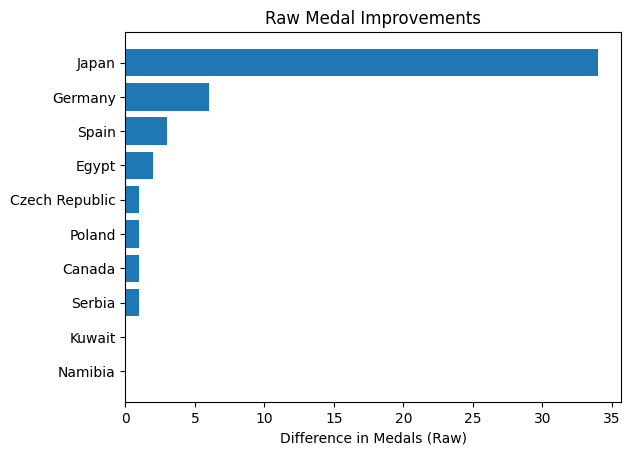

In [311]:
fig, ax = plt.subplots()

ax.barh(most_improved_raw.loc[:9, 'NOC'], most_improved_raw.loc[:9, 'Difference'], align='center')
ax.set_yticks(most_improved_raw.index.values[:10], labels=most_improved_raw.loc[:9, 'NOC'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference in Medals (Raw)')
ax.set_title('Raw Medal Improvements')

plt.savefig("raw_medal_improvements.png")
plt.show()

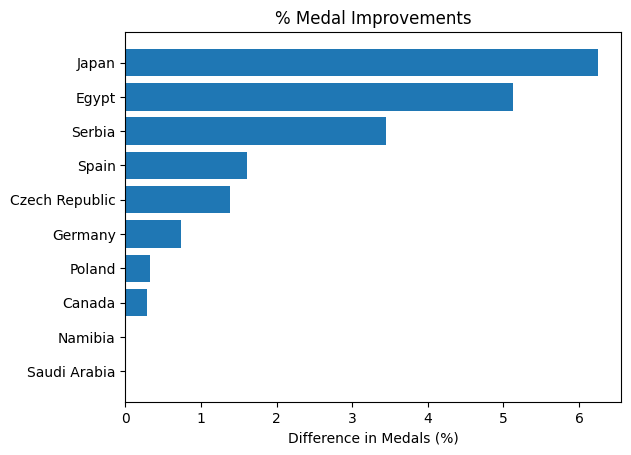

In [312]:
fig, ax = plt.subplots()

ax.barh(most_improved_pct.loc[:9, 'NOC'], most_improved_pct.loc[:9, '% Difference'] * 100, align='center')
ax.set_yticks(most_improved_pct.index.values[:10], labels=most_improved_pct.loc[:9, 'NOC'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference in Medals (%)')
ax.set_title('% Medal Improvements')

plt.savefig("pct_medal_improvements.png")
plt.show()

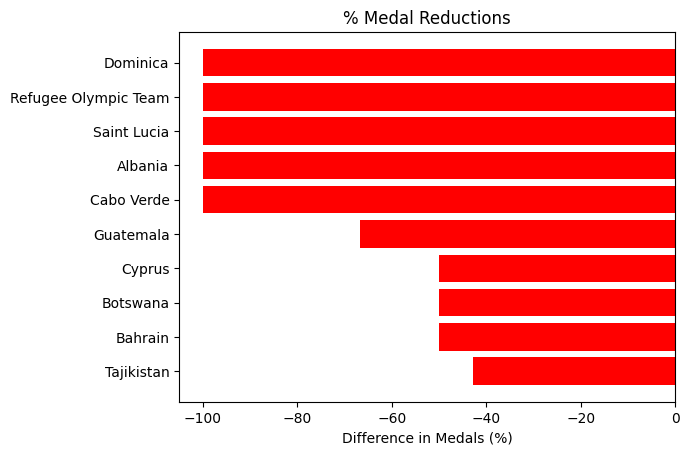

In [313]:
least_improved_pct = most_improved.sort_values(by='% Difference', ascending=True).loc[most_improved['Year'] == 2028].reset_index(drop=True)


fig, ax = plt.subplots()
ax.barh(least_improved_pct.loc[:9, 'NOC'], least_improved_pct.loc[:9, '% Difference'] * 100, align='center', color='red')
ax.set_yticks(least_improved_pct.index.values[:10], labels=least_improved_pct.loc[:9, 'NOC'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference in Medals (%)')
ax.set_title('% Medal Reductions')
plt.savefig("pct_medal_reductions.png")
plt.show()

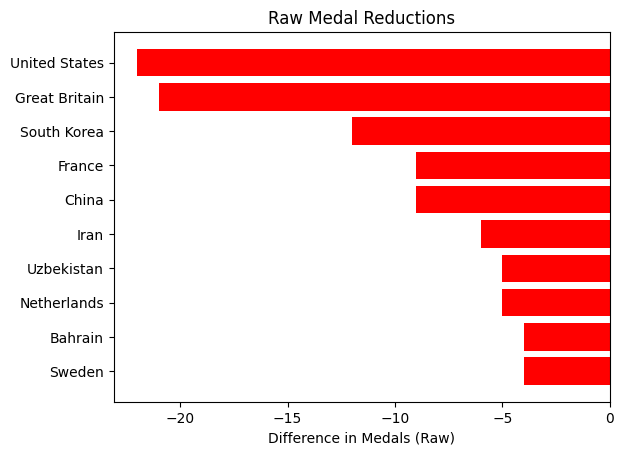

In [314]:

least_improved_raw = most_improved.sort_values(by='Difference', ascending=True).loc[most_improved['Year'] == 2028].reset_index(drop=True)


fig, ax = plt.subplots()
ax.barh(least_improved_raw.loc[:9, 'NOC'], least_improved_raw.loc[:9, 'Difference'], align='center', color='red')
ax.set_yticks(least_improved_raw.index.values[:10], labels=least_improved_raw.loc[:9, 'NOC'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference in Medals (Raw)')
ax.set_title('Raw Medal Reductions')
plt.savefig("raw_medal_reductions.png")
plt.show()